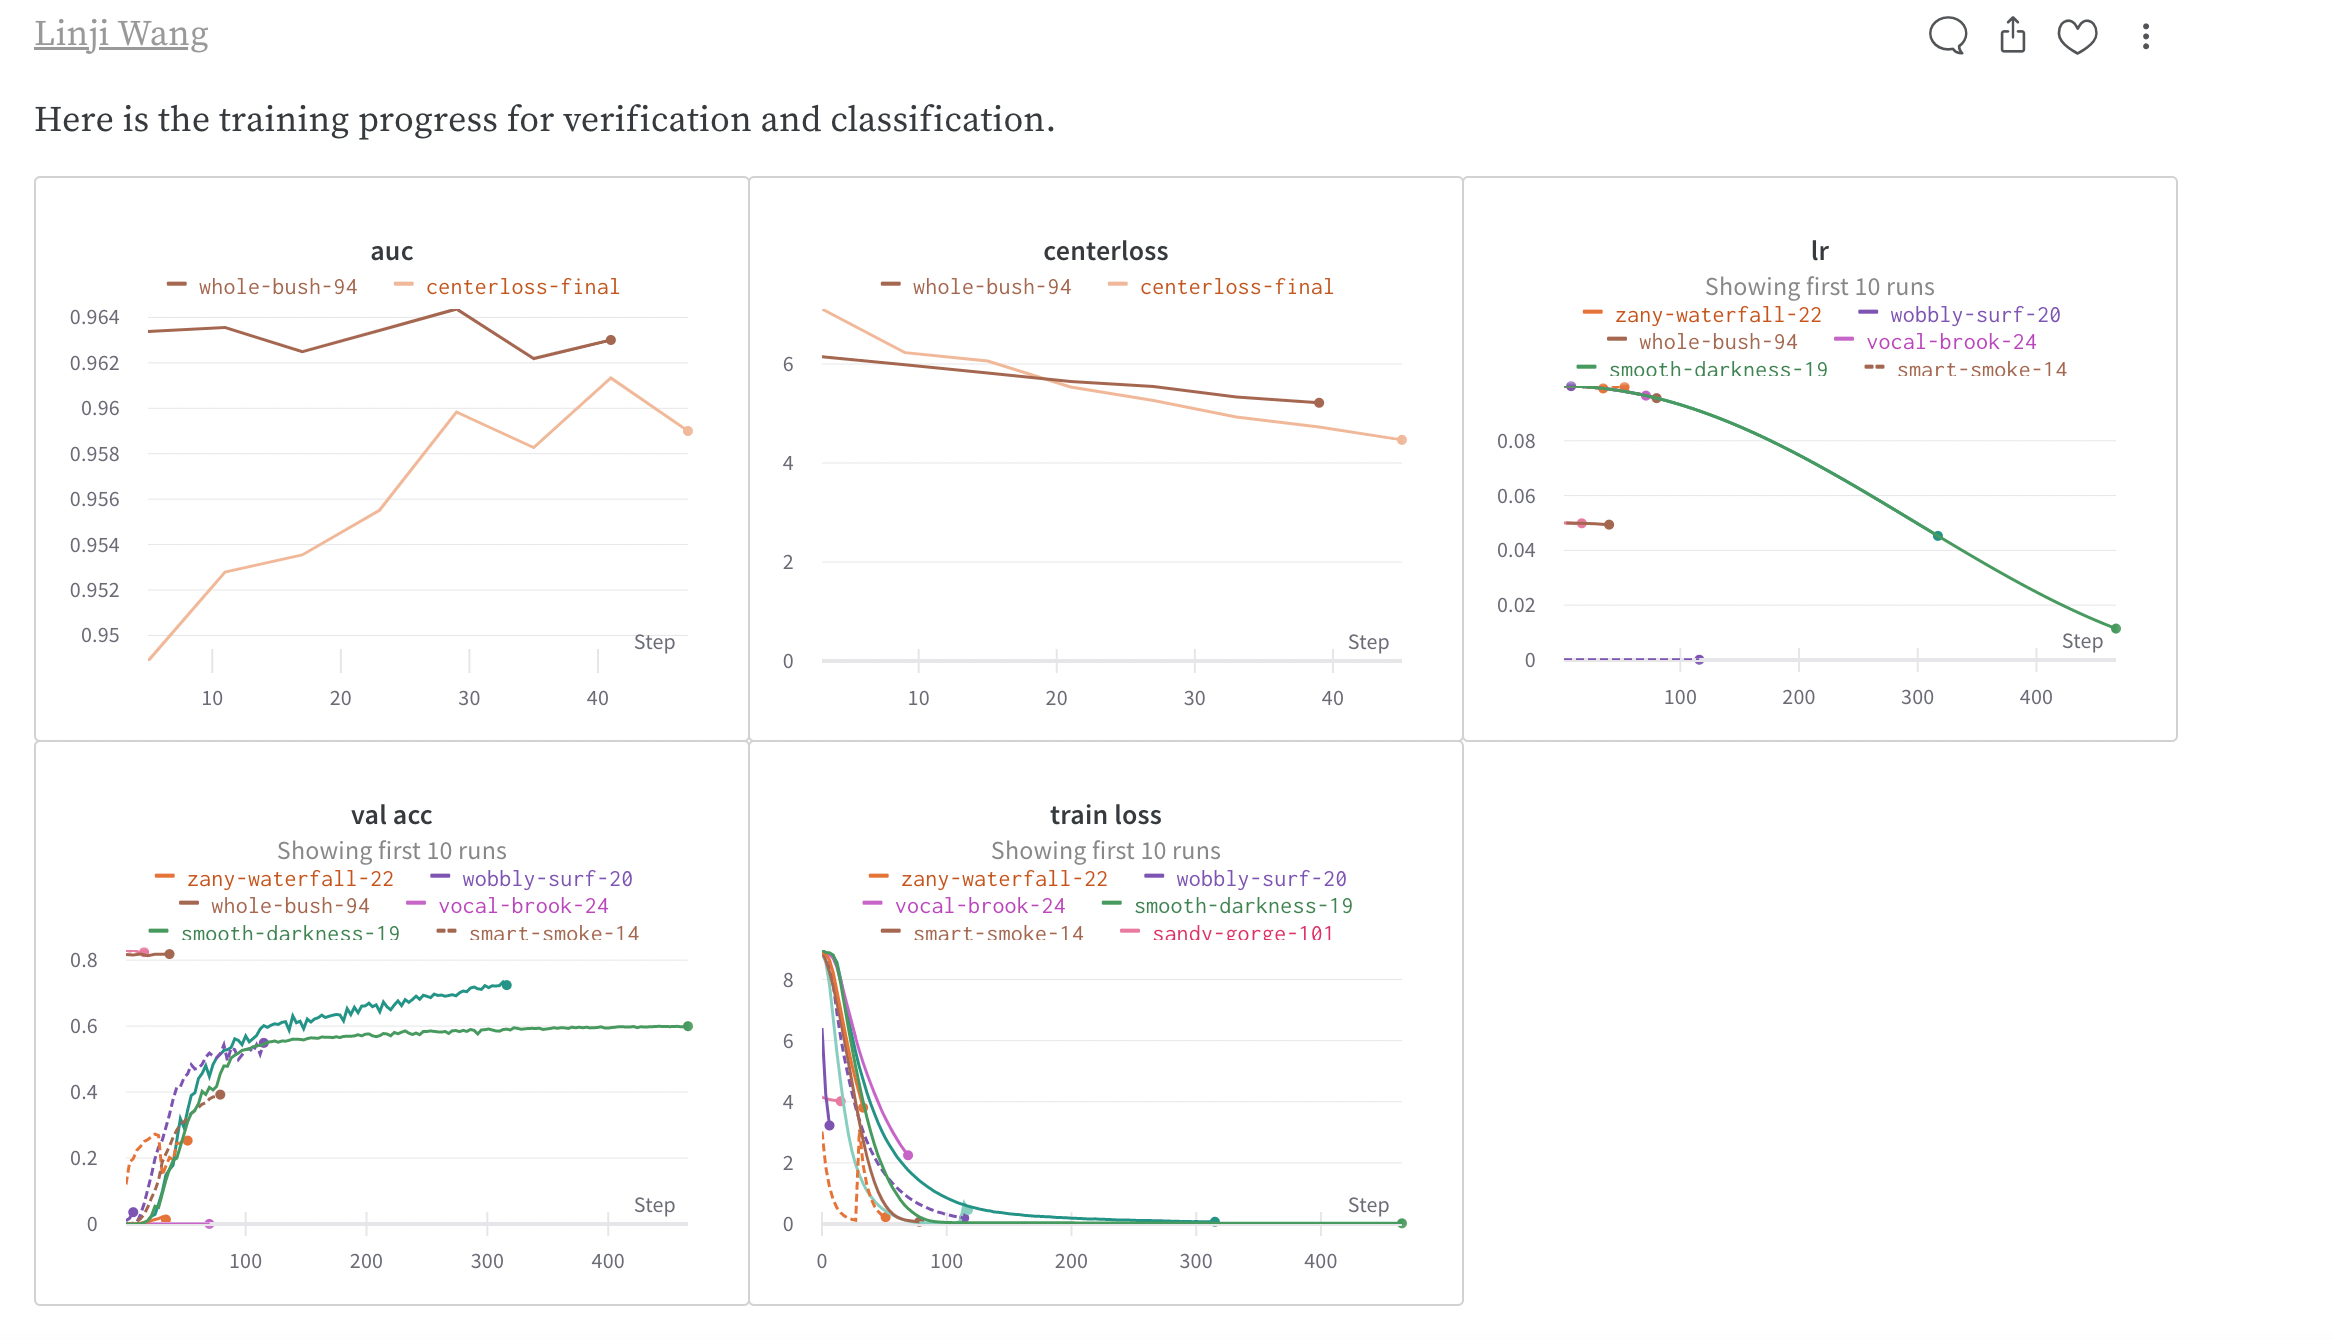

<iframe src="https://wandb.ai/linjiw/hw2pw/reports/HW2P2--VmlldzoxNzY0OTYy?accessToken=2kz0d58dbrl415wign8hxj7z4cevm2zk9gbm3vy7k13bep9vpufe9njgasqh12pa" style="border:none;height:1024px;width:100%">

## log in kaggle -> download dataset -> unzip dataset


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"todo","key":"todo"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 11-785-s22-hw2p2-classification
!kaggle competitions download -c 11-785-s22-hw2p2-verification

!unzip -q 11-785-s22-hw2p2-classification.zip
!unzip -q 11-785-s22-hw2p2-verification.zip

!ls

## log wandb -> record running data

In [ ]:
!pip install wandb
!wandb login
# your key

In [ ]:
import wandb

wandb.init(project="hw2pw", entity="linjiw")

## connect google drive for model store

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision

import torchvision.transforms as ttf
from torch import Tensor

import os
import os.path as osp

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import numpy as np
import torch.nn.init as init
from datetime import datetime
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

import torch
from torch.autograd import Variable, Function
 
# import torchvision.transforms as T



## Centerloss implementation

##Centeloss

In [ ]:
class CenterLoss(nn.Module):
     """Center loss.
    Reference:
    A Discriminative Feature Learning Approach for Deep Face Recognition.
    reimplementation regards Centerloss github.
    """
    def __init__(self, num_classes=10, feat_dim=2):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim

        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())


    def forward(self, x, labels):
 
        batch_size = x.size(0)
        dist1 = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes)
        dist2 = torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat = dist1 + dist2
        distmat.addmm_(1, -2, x, self.centers.t())
        classes = torch.arange(self.num_classes).long()
        classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        center = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * center.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

## Resnet18 implementation and override method for verification

In [ ]:
# resnet18 = models.resnet18(pretrained=True)
num_classes = 7000
class revisednet(models.ResNet):
    
    def _forward_impl(self, x: Tensor, return_feats=False) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        # print(f"feats {feats.shape}")
        out = self.fc(feats)
        
        return feats, out
        # if return_feats:
        #     return feats
        # else:
        #     return out

        # return x
    def forward(self, x: Tensor,return_feats=False) -> Tensor:
        return self._forward_impl(x,return_feats=False)
BasicBlock = models.resnet.BasicBlock

Network = revisednet(BasicBlock, [2,2,2,2])
Network.fc = nn.Linear(512,7000)

# Hyperparameters

In [ ]:
"""
The well-accepted SGD batch_size & lr combination for CNN classification is 256 batch size for 0.1 learning rate.
When changing batch size for SGD, follow the linear scaling rule - halving batch size -> halve learning rate, etc.
This is less theoretically supported for Adam, but in my experience, it's a decent ballpark estimate.
"""
num_classes = 7000
batch_size = 256
lr = 0.03
epochs = 200 # Just for the early submission. We'd want you to train like 50 epochs for your main submissions.

wandb.config = {
  "learning_rate": 0.03,
  "epochs": 100,
  "batch_size": 256
}

# Dataset & DataLoader

## Classification dataset and dataloader

In [ ]:
"""
Transforms (data augmentation) is quite important for this task.
Go explore https://pytorch.org/vision/stable/transforms.html for more details
"""
DATA_DIR = "/content"
# TRAIN_DIR = osp.join(DATA_DIR, "train_subset/train_subset") # This is a smaller subset of the data. Should change this to classification/classification/train
TRAIN_DIR = osp.join(DATA_DIR, "classification/classification/train")
VAL_DIR = osp.join(DATA_DIR, "classification/classification/dev")
TEST_DIR = osp.join(DATA_DIR, "classification/classification/test")

# train_transforms = [ttf.ToTensor(),ttf.RandomRotation((-90,90)),ttf.RandomAdjustSharpness(1.5),ttf.RandomHorizontalFlip(p=0.5),ttf.RandomVerticalFlip(p=0.5),ttf.RandomPerspective(distortion_scale=0.5,p=0.5) ] ,ttf.RandomVerticalFlip(p=0.2),
# val_transforms = [ttf.ToTensor()],ttf.RandomRotation((-5,5),fill=20)
# train_transforms = [   ttf.ToTensor(),ttf.RandomHorizontalFlip(p=0.5),ttf.RandomVerticalFlip(p=0.01),ttf.RandomAffine(degrees=(-5,5),scale=(1,1.05)),ttf.ColorJitter(brightness=0.2,hue=0.05,contrast=0.2,saturation=0.05),ttf.Resize((224,224)),ttf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]

# val_transforms = [   ttf.ToTensor(),ttf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ]
train_transforms = [ttf.ToTensor(),ttf.RandomHorizontalFlip(p=0.5),ttf.RandomInvert(p=0.01),ttf.RandomAffine(degrees=(-5,5),scale=(1,1.05)),ttf.ColorJitter(brightness=0.3,hue=0.2,contrast=0.3,saturation=0.2),ttf.Resize((224,224)),ttf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]

val_transforms = [ttf.ToTensor(),ttf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ]

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR,
                                                 transform=ttf.Compose(train_transforms))
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR,
                                               transform=ttf.Compose(val_transforms))




train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        drop_last=True, num_workers=4)

## Visualize Transformation to have a better understanding what's going on under the hood

In [ ]:
sample_image_pth = osp.join(TRAIN_DIR,os.listdir(TRAIN_DIR)[0])
# print(os.listdir(TRAIN_DIR))
sample_image_pth = osp.join(sample_image_pth,os.listdir(sample_image_pth)[0])

print(sample_image_pth)

/content/classification/classification/train/n004976/0014_01.jpg


In [ ]:
orig_img = Image.open(sample_image_pth)
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


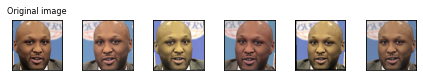

In [ ]:
transform=ttf.Compose(train_transforms[1:-1])
transformed_img = [transform(orig_img) for i in range(5)]
plot(transformed_img)

## Verification dataset and dataloader

In [ ]:
class VerificationDataset(Dataset):
    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # We return the image, as well as the path to that image (relative path)
        return self.transforms(Image.open(self.img_paths[idx])), osp.relpath(self.img_paths[idx], self.data_dir)

In [ ]:
val_veri_dataset = VerificationDataset(osp.join(DATA_DIR, "verification/verification/dev"),
                                       ttf.Compose(val_transforms))
val_ver_loader = torch.utils.data.DataLoader(val_veri_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=1)

# Setup everything for training

Now this step is fine tuning of my pretrained classification model, and I am trying to add centerloss to make it performs better for verification.

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss

lr = 0.03
model = Network
# model = mobilenet
# model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/model/156_27_02_2022_21_08.pth")) best
# model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/model/best_mobilev3_onlyflip.pth"))
# 23_09_03_2022_06_25 81
# 9_10_03_2022_00_39 82
# model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/model/54_08_03_2022_22_45.pth")) #79.6
# model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/model/9_10_03_2022_00_39.pth")) #81
# /content/drive/MyDrive/hw2p2/11-785-s22-hw2p2-classification/model/0.8428%_84_10_03_2022_19_09.pth
# model.load_state_dict(torch.load("/content/drive/MyDrive/11785/hw2p2/aws/model/8542.pth"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/11-785-s22-hw2p2-classification/model/0.8428%_84_10_03_2022_19_09.pth"))
model.load_state_dict(torch.load("/content/drive/MyDrive/hw2p2/model/5_22_03_2022_02_23.pth"))
model.cuda()

# For this homework, we're limiting you to 35 million trainable parameters, as
# outputted by this. This is to help constrain your search space and maintain
# reasonable training times & expectations
num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))

# TODO: What criterion do we use for this task?
# criterion = 
center_loss = CenterLoss(7000,512)
criterion = CrossEntropyLoss(label_smoothing=0.3)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
c_loss_optimi = optim.SGD(center_loss.parameters(), lr=0.05)
c_loss_weight = 0.001
# optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
# T_max is "how many times will i call scheduler.step() until it reaches 0 lr?"

# For this homework, we strongly strongly recommend using FP16 to speed up training.
# It helps more for larger models.
# Go to https://effectivemachinelearning.com/PyTorch/8._Faster_training_with_mixed_precision
# and compare "Single precision training" section with "Mixed precision training" section


scaler = torch.cuda.amp.GradScaler()

Number of Params: 14767512


## Call wandb to watch the model.

In [ ]:
wandb.watch(model, log_freq=100)


[]

# Let's train!

## call verification metric for validation

In [ ]:
from scipy.spatial.distance import cosine
cos = nn.CosineSimilarity(dim=0, eps=1e-6)


similarity_metric = cosine
similarity_metric = cos


val_veri_csv = osp.join(DATA_DIR, "verification/verification/verification_dev.csv")


In [ ]:
for epoch in range(epochs):
    # Quality of life tip: leave=False and position=0 are needed to make tqdm usable in jupyter
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    num_correct = 0
    total_loss = 0
    total_c_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        # with torch.cuda.amp.autocast():     
        feats, outputs = model(x)
        c_loss = center_loss(feats, y )*c_loss_weight
        loss = criterion(outputs, y) + c_loss

        # Update # correct & loss as we go
        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)
        total_c_loss +=float(c_loss)
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            c_loss="{:.04f}".format(float(total_c_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Another couple things you need for FP16. 
         # This is a replacement for loss.backward()
         # This is a replacement for optimizer.step()
        optimizer.zero_grad()
        c_loss_optimi.zero_grad()

        # scaler.scale(loss).backward()
        loss.backward()
        # c_loss.backward()
        # optimizer.step()
        c_loss_optimi.step()
        optimizer.step()
        # scaler.step(optimizer)
        for param in center_loss.parameters():
            param.grad.data *= (1. / c_loss_weight)
        c_loss_optimi.step()
        
        # scaler.update() # This is something added just for FP16

        scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # You need this to close the tqdm bar
    now = datetime.now()
    # pth = "/content/drive/MyDrive/11785/model/"
    name = now.strftime("%d_%m_%Y_%H_%M")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/hw2p2/model/{epoch}_{name}.pth")
    # You can add validation per-epoch here if you would like
 
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    val_num_correct = 0
    for i, (x, y) in enumerate(val_loader):

        x = x.cuda()
        y = y.cuda()

        with torch.no_grad():
            feats,outputs = model(x)

        val_num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        batch_bar.set_postfix(acc="{:.04f}%".format(100 * val_num_correct / ((i + 1) * batch_size)))

        batch_bar.update()
    
    batch_bar.close()
    print("Validation: {:.04f}%".format(100 * val_num_correct / len(val_dataset)))
    val_acc = val_num_correct / len(val_dataset)
    wandb.log({"train loss": float(total_loss / len(train_loader))})
    wandb.log({"val acc": val_acc})
    wandb.log({"lr": float(optimizer.param_groups[0]['lr'])})

    feats_dict = dict()
    for batch_idx, (imgs, path_names) in tqdm(enumerate(val_ver_loader), total=len(val_ver_loader), position=0, leave=False):
        imgs = imgs.cuda()

        with torch.no_grad():
            # Note that we return the feats here, not the final outputs
            # Feel free to try to final outputs too!
            feats,_ = model(imgs) 
            # feats = model(imgs, return_feats=True) 
            for i,j in zip(feats,path_names):
                feats_dict.update({j: i})
    pred_similarities = []
    gt_similarities = []
    for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=False): # skip header
        img_path1, img_path2, gt = line.split(",")


        feats1 = feats_dict[img_path1[4:]]
        feats2 = feats_dict[img_path2[4:]]

        pred = float(similarity_metric(feats1,feats2))


        gt_similarities.append(int(gt))
        pred_similarities.append(pred)

    pred_similarities = np.array(pred_similarities)
    gt_similarities = np.array(gt_similarities)

    print("AUC:", roc_auc_score(gt_similarities, pred_similarities))
    
    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        100 * num_correct / (len(train_loader) * batch_size),
        
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr'])))

# Classification Task: Validation

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/hw2p2/model/34_01_03_2022_04_18.pth'))
model.eval()
batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
num_correct = 0
for i, (x, y) in enumerate(val_loader):

    x = x.cuda()
    y = y.cuda()

    with torch.no_grad():
        outputs = model(x)

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

    batch_bar.update()
    
batch_bar.close()
print("Validation: {:.04f}%".format(100 * num_correct / len(val_dataset)))

Validation: 84.2771%


# Classification Task: Submit to Kaggle

In [ ]:
class ClassificationTestSet(Dataset):
    # It's possible to load test set data using ImageFolder without making a custom class.
    # See if you can think it through!

    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestSet(TEST_DIR, ttf.Compose(val_transforms))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=False, num_workers=1)

In [ ]:
model.eval()
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')

res = []
for i, (x) in enumerate(test_loader):
    x = x.cuda()
    # TODO: Finish predicting on the test set.
    with torch.no_grad():
        outputs = model(x)
    pred_y = torch.argmax(outputs, axis=1)
    res.extend(pred_y.tolist())

    batch_bar.update()
    
batch_bar.close()

In [ ]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", res[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s22-hw2p2-classification -f classification_early_submission.csv -m "hello"

100% 541k/541k [00:02<00:00, 275kB/s]
Successfully submitted to Face Recognition

# Verification Task: Validation

There are 6K verification dev images, but 166K "pairs" for you to compare. So, it's much more efficient to compute the features for the 6K verification images, and just compare afterwards.

This will be done by creating a dictionary mapping the image file names to the features. Then, you'll use this dictionary to compute the similarities for each pair.

In [ ]:
!ls verification/verification/dev | wc -l
!cat verification/verification/verification_dev.csv | wc -l

6000
166801


In [ ]:
class VerificationDataset(Dataset):
    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # We return the image, as well as the path to that image (relative path)
        return self.transforms(Image.open(self.img_paths[idx])), osp.relpath(self.img_paths[idx], self.data_dir)

In [ ]:
val_veri_dataset = VerificationDataset(osp.join(DATA_DIR, "verification/verification/dev"),
                                       ttf.Compose(val_transforms))
val_ver_loader = torch.utils.data.DataLoader(val_veri_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=1)

In [ ]:
model.eval()

feats_dict = dict()
for batch_idx, (imgs, path_names) in tqdm(enumerate(val_ver_loader), total=len(val_ver_loader), position=0, leave=False):
    imgs = imgs.cuda()

    with torch.no_grad():
        # Note that we return the feats here, not the final outputs
        # Feel free to try the final outputs too!
        feats = model(imgs, return_feats=True) 
        for i,j in zip(feats,path_names):
            feats_dict.update({j: i})
    # TODO: Now we have features and the image path names. What to do with them?
    # Hint: use the feats_dict somehow.

In [ ]:
# What does this dict look like?
print(list(feats_dict.items())[0])

('000b28b024.jpg', tensor([-32.1187, -31.4586, -26.6701,  ..., -31.4190, -16.7718, -21.3447],
       device='cuda:0'))


In [ ]:
# We use cosine similarity between feature embeddings.
# TODO: Find the relevant function in pytorch and read its documentation.
# similarity_metric = 
from scipy.spatial.distance import cosine
cos = nn.CosineSimilarity(dim=0, eps=1e-6)


similarity_metric = cosine
similarity_metric = cos


val_veri_csv = osp.join(DATA_DIR, "verification/verification/verification_dev.csv")


# Now, loop through the csv and compare each pair, getting the similarity between them
pred_similarities = []
gt_similarities = []
for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=False): # skip header
    img_path1, img_path2, gt = line.split(",")


    feats1 = feats_dict[img_path1[4:]]
    feats2 = feats_dict[img_path2[4:]]

    pred = float(similarity_metric(feats1,feats2))


    gt_similarities.append(int(gt))
    pred_similarities.append(pred)

pred_similarities = np.array(pred_similarities)
gt_similarities = np.array(gt_similarities)

print("AUC:", roc_auc_score(gt_similarities, pred_similarities))

AUC: 0.9535921937670002


In [ ]:
input1 = torch.ones(100)
input2 = torch.ones(100)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(input1, input2)
print(output)

tensor(1.)


# Verification Task: Submit to Kaggle

In [ ]:
test_veri_dataset = VerificationDataset(osp.join(DATA_DIR, "verification/verification/test"),
                                        ttf.Compose(val_transforms))
test_ver_loader = torch.utils.data.DataLoader(test_veri_dataset, batch_size=batch_size, 
                                              shuffle=False, num_workers=1)

In [ ]:
model.eval()

feats_dict = dict()
for batch_idx, (imgs, path_names) in tqdm(enumerate(test_ver_loader), total=len(test_ver_loader), position=0, leave=False):
    imgs = imgs.cuda()

    with torch.no_grad():
        # Note that we return the feats here, not the final outputs
        # Feel free to try to final outputs too!
        feats = model(imgs, return_feats=True) 
        # feats = model(imgs, return_feats=True) 
        for i,j in zip(feats,path_names):
            feats_dict.update({j: i})
    # TODO: Now we have features and the image path names. What to do with them?
    # Hint: use the feats_dict somehow.

In [ ]:
# We use cosine similarity between feature embeddings.
# TODO: Find the relevant function in pytorch and read its documentation.
# similarity_metric = 
from scipy.spatial.distance import cosine
cos = nn.CosineSimilarity(dim=0, eps=1e-6)


similarity_metric = cosine
similarity_metric = cos
val_veri_csv = osp.join(DATA_DIR, "verification/verification/verification_test.csv")


# Now, loop through the csv and compare each pair, getting the similarity between them
pred_similarities = []
for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=False): # skip header
    img_path1, img_path2 = line.split(",")
    feats1 = feats_dict[img_path1[5:]]
    feats2 = feats_dict[img_path2[5:]]

    pred = float(similarity_metric(feats1,feats2))
    pred_similarities.append(pred)
    # TODO: Finish up verification testing.
    # How to use these img_paths? What to do with the features?
pred_similarities = np.array(pred_similarities)


In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,match\n")
    for i in range(len(pred_similarities)):
        f.write("{},{}\n".format(i, pred_similarities[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s22-hw2p2-verification -f verification_early_submission.csv -m "test"

100% 16.9M/16.9M [00:03<00:00, 4.62MB/s]
Successfully submitted to Face Verification

# Extras

In [ ]:
# If you keep re-initializing your model in Colab, can run out of GPU memory, need to restart.
# These three lines can help that - run this before you re-initialize your model


# del model
torch.cuda.empty_cache()
!nvidia-smi

Mon Mar 21 20:35:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------